
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 10 (демо)
## <center> Прогнозирование задержек вылетов

Ваша задача – побить единственный бенчмарк в [соревновании](https://www.kaggle.com/c/flight-delays-2017) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен этот бенчмарк. Конечно, с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит Xgboost. Но проверьте еще Catboost.

<img src='../../img/xgboost_meme.jpg' width=40% />

In [40]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [138]:
train = pd.read_csv("../../data/flight_delays_train.csv")
test = pd.read_csv("../../data/flight_delays_test.csv")

In [3]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [11]:
test.shape

(100000, 8)

In [4]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Итак, надо по времени вылета самолета, коду авиакомпании-перевозчика, месту вылета и прилета и расстоянию между аэропортами вылета и прилета предсказать задержку вылета более 15 минут. В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: `DepTime` и `Distance`. У такой модели результат – 0.68202 на LB. 

In [93]:
X_train, y_train = (
    train[["Distance", "DepTime"]].values,
    train["dep_delayed_15min"].map({"Y": 1, "N": 0}).values,
)
X_test = test[["Distance", "DepTime"]].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=17
)

In [6]:
logit = LogisticRegression(random_state=17)

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.6795697123357751

In [7]:
logit.fit(X_train, y_train)
logit_test_pred = logit.predict_proba(X_test)[:, 1]

pd.Series(logit_test_pred, name="dep_delayed_15min").to_csv(
    "logit_2feat.csv", index_label="id", header=True
)

In [18]:
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer

In [139]:
train = pd.get_dummies(train, columns=['Month','DayofMonth','DayOfWeek', 'UniqueCarrier', 'Origin','Dest'])

In [140]:
train["dep_delayed_15min"] = train["dep_delayed_15min"].map({"Y": 1, "N": 0})

In [141]:
train.head()

,DepTime,Distance,dep_delayed_15min,Month_c-1,Month_c-10,Month_c-11,Month_c-12,Month_c-2,Month_c-3,Month_c-4,...,Dest_TYS,Dest_VCT,Dest_VIS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YUM
0,1934,732,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1548,834,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1422,416,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1015,872,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1828,423,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train.drop("dep_delayed_15min", axis=1),
    train["dep_delayed_15min"],
    test_size=0.3,
    stratify=train["dep_delayed_15min"],
    random_state=17,
)

In [143]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_valid, y_valid)

In [146]:
params = {"objective": "binary:logistic", "max_depth": 3, "silent": 1, "eta": 1}

num_rounds = 100

In [148]:
params["eval_metric"] = "auc"

In [149]:
watchlist = [(dtest, "test"), (dtrain, "train")]  # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[00:06:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	test-auc:0.68945	train-auc:0.68103
[1]	test-auc:0.70085	train-auc:0.69300
[2]	test-auc:0.70647	train-auc:0.69946
[3]	test-auc:0.71160	train-auc:0.70617
[4]	test-auc:0.71488	train-auc:0.71068
[5]	test-auc:0.71792	train-auc:0.71353
[6]	test-auc:0.71831	train-auc:0.71591
[7]	test-auc:0.71983	train-auc:0.71757
[8]	test-auc:0.72144	train-auc:0.71985
[9]	test-auc:0.72090	train-auc:0.72174
[10]	test-auc:0.72182	train-auc:0.72348
[11]	test-auc:0.72315	train-auc:0.72454
[12]	test-auc:0.72361	train-auc:0.72589
[13]	test-auc:0.72505	train-auc:0.72769
[14]	

In [130]:
preds_prob = xgb_model.predict(dtest)

In [29]:
roc_auc_score(y_valid, preds_prob)

0.7324013978617665

**Пробуем LightGBM**

In [163]:
from lightgbm import LGBMRegressor

In [164]:
lgb_clf = LGBMRegressor(random_state=17)

In [165]:
%%time
lgb_clf.fit(X_train, y_train)

CPU times: user 1.9 s, sys: 438 ms, total: 2.34 s
Wall time: 501 ms


LGBMRegressor(random_state=17)

In [166]:
roc_auc_score(y_valid, lgb_clf.predict(X_valid))

0.7482215001854645

In [168]:
param_grid = {'num_leaves': [7, 15, 31, 63], 
              'max_depth': [3, 4, 5, 6, -1]}

In [169]:
grid_searcher = GridSearchCV(estimator=lgb_clf, param_grid=param_grid, 
                             cv=5, verbose=1, n_jobs=-1)

In [170]:
grid_searcher.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, -1],
                         'num_leaves': [7, 15, 31, 63]},
             verbose=1)

In [171]:
grid_searcher.best_params_, grid_searcher.best_score_

({'max_depth': -1, 'num_leaves': 63}, 0.13090327042999209)

In [172]:
roc_auc_score(y_valid, grid_searcher.predict(X_valid))

0.7508320676965592

**Пробуем CatBoost**

In [45]:
from catboost import CatBoostClassifier, Pool, metrics, cv

In [101]:
model = CatBoostClassifier(
    custom_loss=[metrics.AUC()],
    random_seed=42,
    logging_level='Silent'
)

In [102]:
categorical_features_indices = np.where(train.dtypes != float)[0]

In [105]:
model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [109]:
predictions_probs = model.predict_proba(X_valid)[:,1]

In [110]:
roc_auc_score(y_valid, predictions_probs)

0.7567820590159405

Как был получен бенчмарк в соревновании:
- Признаки `Distance` и  `DepTime` брались без изменений
- Создан признак "маршрут" из исходных `Origin` и `Dest`
- К признакам `Month`, `DayofMonth`, `DayOfWeek`, `UniqueCarrier` и "маршрут" применено OHE-преобразование (`LabelBinarizer`)
- Выделена отложенная выборка
- Обучалась логистическая регрессия и градиентный бустинг (xgboost), гиперпараметры бустинга настраивались на кросс-валидации, сначала те, что отвечают за сложность модели, затем число деревьев фиксировалось равным 500 и настраивался шаг градиентного спуска
- С помощью `cross_val_predict` делались прогнозы обеих моделей на кросс-валидации (именно предсказанные вероятности), настраивалась линейная смесь ответов логистической регрессии и градиентного бустинга вида $w_1 * p_{logit} + (1 - w_1) * p_{xgb}$, где $p_{logit}$ – предсказанные логистической регрессией вероятности класса 1, $p_{xgb}$ – аналогично. Вес $w_1$ подбирался вручную. 
- В качестве ответа для тестовой выборки бралась аналогичная комбинация ответов двух моделей, но уже обученных на всей обучающей выборке.

Описанный план ни к чему не обязывает – это просто то, как решение получил автор задания. Возможно, мы не захотите следовать намеченному плану, а добавите, скажем, пару хороших признаков и обучите лес из тысячи деревьев.

Удачи!

In [137]:
X_valid

,DepTime,Distance,Month_c-1,Month_c-10,Month_c-11,Month_c-12,Month_c-2,Month_c-3,Month_c-4,Month_c-5,...,Dest_TYS,Dest_VCT,Dest_VIS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YUM
94584,1147,296,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76365,955,299,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
52021,1120,388,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60846,2244,665,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65766,1005,508,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,1303,999,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
62496,559,925,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5717,1225,848,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77995,951,859,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Пробуем Hyperopt с XGboost**

In [111]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [157]:
def score(params):
    from sklearn.metrics import roc_auc_score

    print("Training with params:")
    print(params)
    params["max_depth"] = int(params["max_depth"])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    model = xgb.train(params, dtrain, params["num_round"])
    predictions = model.predict(dvalid)
    score = roc_auc_score(y_valid, predictions)
    print("\tScore {0}\n\n".format(score))
    return {"loss": 1 - score, "status": STATUS_OK}

In [158]:
def optimize(trials):
    space = {
        "num_round": 100,
        "learning_rate": hp.quniform("eta", 0.005, 0.05, 0.005),
        "max_depth": hp.quniform("max_depth", 3, 14, 1),
        "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
        "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
        "gamma": hp.quniform("gamma", 0.5, 1, 0.01),
        "colsample_bytree": hp.quniform("colsample_bytree", 0.4, 1, 0.05),
        "eval_metric": "auc",
        "objective": "binary:logistic",
        "nthread": 4,
        "silent": 1,
    }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=10, rstate=np.random.default_rng(50))
    return best

In [159]:
trials = Trials()
best_params = optimize(trials)
best_params

Training with params:                                                           
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'auc', 'gamma': 0.76, 'learning_rate': 0.045, 'max_depth': 7.0, 'min_child_weight': 7.0, 'nthread': 4, 'num_round': 100, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.75}
[00:13:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


	Score 0.7385055387204781                                                       


Training with params:                                                           
{'colsample_bytree': 0.55, 'eval_metric': 'auc', 'gamma'

	Score 0.7168834937875433                                                       


100%|████████| 10/10 [08:34<00:00, 51.42s/trial, best loss: 0.24734583119963482]


{'colsample_bytree': 0.6000000000000001,
 'eta': 0.035,
 'gamma': 0.56,
 'max_depth': 14.0,
 'min_child_weight': 5.0,
 'subsample': 1.0}

In [180]:
dtrain = xgb.DMatrix(X_valid, y_valid)

In [175]:
best_params["max_depth"] = int(best_params["max_depth"])
best_params["eval_metric"] = "auc"
best_params["objective"] = "binary:logistic"
best_params["nthread"] = 4
best_params["silent"] = 1

In [181]:
%%time
xgbCvResult = xgb.cv(
    best_params, dtrain, num_boost_round=500, nfold=3, early_stopping_rounds=50
)

[00:29:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:29:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:29:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost

In [182]:
xgbCvResult

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.751987,0.003594,0.695968,0.004124
1,0.769211,0.001537,0.703187,0.007182
2,0.780264,0.001315,0.707657,0.007935
3,0.783139,0.000853,0.710825,0.006537
4,0.785734,0.002522,0.711827,0.006399
...,...,...,...,...
198,0.898244,0.002153,0.731561,0.005248
199,0.898424,0.002125,0.731590,0.005253
200,0.898578,0.002209,0.731589,0.005220
201,0.898808,0.002322,0.731655,0.005208


In [184]:

%matplotlib inline
import matplotlib.pyplot as plt

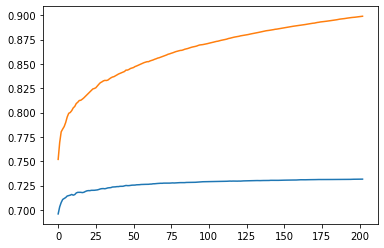

In [185]:
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult["test-auc-mean"])
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult["train-auc-mean"]);

In [187]:
best_num_round = np.argmax(xgbCvResult["test-auc-mean"])
best_num_round

202